<a href="https://colab.research.google.com/github/XXXXiner/Deep-Learning/blob/main/lab09_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9: Reinforcement Learning

##Set up

First, you need the most recent version of gym.

In [ ]:
!pip install gym --upgrade
!pip install gymnasium --upgrade
!pip install pygame --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827619 sha256=5b7cae66468a0b61d9915d67b32c8400ac8b0302b480e2d5f57214495b7e6525
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.4 MB/s eta 0:00:00


Then, if you are running on Colab, you have to tell pygame that there is no display device in Colab. Otherwise, it would get confused.

In [ ]:
import os
import sys

isColab = "google.colab" in sys.modules
# this also works:
# isColab = "COLAB_GPU" in os.environ

if isColab:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)

    colab_path = ("/content/drive/My Drive"
        + "/CSCI 2470 Deep Learning/Lab 9")

Mounted at /content/drive


Always be careful with filepaths when you are working on Colab.

In [ ]:
TA_model_path = "TA_model.gif"
untrained_model_path = "untrained_model.gif"
trained_model_path = "trained_model.gif"

if isColab:
    TA_model_path = f"{colab_path}/{TA_model_path}"
    untrained_model_path = f"{colab_path}/{untrained_model_path}"
    trained_model_path = f"{colab_path}/{trained_model_path}"

In [ ]:
import gymnasium as gym # Cart Pole
import PIL # Create animated GIF
import IPython as ip # Display animated GIF

import numpy as np
import tensorflow as tf
# Killing optional CPU driver warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import matplotlib as mpl

## Cart Pole

Let's first consider this game of Cart Pole and learn the new key terminologies: **episode**, **state**, **action**, and **reward**.

The goal of the game is to keep the pole straight up by pushing the cart to the appropriate direction, and OpenAI's `gym` package provides a nice [API to play the game](https://gymnasium.farama.org/environments/classic_control/cart_pole/#cart-pole) in Python.

Below is an example of a model trained by the TAs.

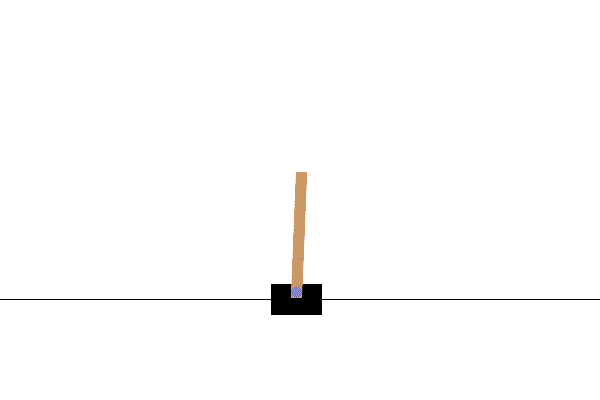

In [ ]:
ip.display.Image(open(TA_model_path,"rb").read())

In [ ]:
# set up an environment for Cart Pole game
env = gym.make("CartPole-v1", render_mode="rgb_array")

state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

In this game:
- You push the cart either left or right with the force of 10.0 Newtons (`env.unwrapped.force_mag`), every 0.02 seconds (`env.unwrapped.tau`), until the game ends.
- The masses of the cart and the pole are 1.0 kilograms and 0.1 kilograms (`env.unwrapped.masscart` and `env.unwrapped.masspole`), repectively, and the half length of the pole is 0.5 meters (`env.unwrapped.length`).
- The game plays with the standard gravity of 9.8 $\mathrm{m}/\mathrm{s}^2$ (`env.unwrapped.gravity`).

You can change this set-up by modifying the appropriate variables encapsulated in the object `env.unwrapped`.

In [ ]:
print(f"force to push the cart {env.unwrapped.force_mag}")
print(f"time between each cart push: {env.unwrapped.tau}")
# honestly, why did they use the name tau, instead of the more intuitive delta_t?
print("")
print(f"mass of the cart: {env.unwrapped.masscart}")
print(f"mass of the pole: {env.unwrapped.masspole}")
print(f"half-length of the pole: {env.unwrapped.length}")
# it is half-length rather than the full length
# actually, it is the distance between the cart fulcrum and the center of mass of the pole
print("")
print(f"gravity: {env.unwrapped.gravity}")

force to push the cart 10.0
time between each cart push: 0.02

mass of the cart: 1.0
mass of the pole: 0.1
half-length of the pole: 0.5

gravity: 9.8


Let's then take a look at the **observation space**, which has the following four variables:

| Index | Observation           | Min               | Max             |
|-------|-----------------------|-------------------|-----------------|
| 0     | Cart Position         | -4.8              | 4.8             |
| 1     | Cart Velocity         | -Inf              | Inf             |
| 2     | Pole Angle            | -0.418 rad (-24°) | 0.418 rad (24°) |
| 3     | Pole Angular Velocity | -Inf              | Inf             |

In [ ]:
print(f"lower bound: {env.observation_space.low}")
print(f"upper bound: {env.observation_space.high}")
print(f"shape: {env.observation_space.shape}")
print(f"dtype: {env.observation_space.dtype}")

lower bound: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
upper bound: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
shape: (4,)
dtype: float32


Then, we have the **action space**. This is the space of actions that can be performed by the agent. For this simple game, the action space is really just a single integer to tell the environment to which direction you want to push the cart.

| Value | Action                 |
|-------|------------------------|
| 0     | Push cart to the left  |
| 1     | Push cart to the right |

In [ ]:
print(f"number of actions: {env.action_space.n}")
print(f"shape: {env.action_space.shape}")
print(f"dtype: {env.action_space.dtype}")

number of actions: 2
shape: ()
dtype: int64


When you reset the environment, you begin a new **episode** of the game with the cart and pole at random positions with random speeds. The reset method returns the initial state, and you can access the current state whenever you want to at `env.unwrapped.state`.

In [ ]:
state, info = env.reset(seed = 42)
print(f"initial state = {state}")
print(f"{state == np.float32(env.unwrapped.state)}")

initial state = [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
[ True  True  True  True]


The **state** in this game is a vector of four elements: cart position, cart velocity, pole angle, pole angular velocity.

From this state, you can make the decision about what your next **action** is going to be. In this game, there are two possible actions, either left or right. Once you've decided which action to take, you can update the environment with the `env.step(action)` method. If `action == 0`, the environment pushes the cart to the left, or if `action == 1`, to the right.

More detailed explanation on the return values can be found in this [doc](https://github.com/openai/gym/blob/master/gym/core.py#L95).

In [ ]:
# let's push the cart to the left for this example
action = 0

state, reward, is_done, is_truncated, info = env.step(action)

print(f"newly updated state = {state}")
print(f"reward received from this step = {reward}")
print(f"is the episde finished? = {is_done}")
print(f"does the agent go out of bound? = {is_truncated}")
print(f"debugging information = {info}")

newly updated state = [ 0.02727336 -0.20172954  0.03625453  0.32351476]
reward received from this step = 1.0
is the episde finished? = False
does the agent go out of bound? = False
debugging information = {}


You can also render the current state of the game as an image, like a screenshot. It's actually a NumPy array of RGB pixel values.

<class 'numpy.ndarray'>
(height, width, channels) = (400, 600, 3)


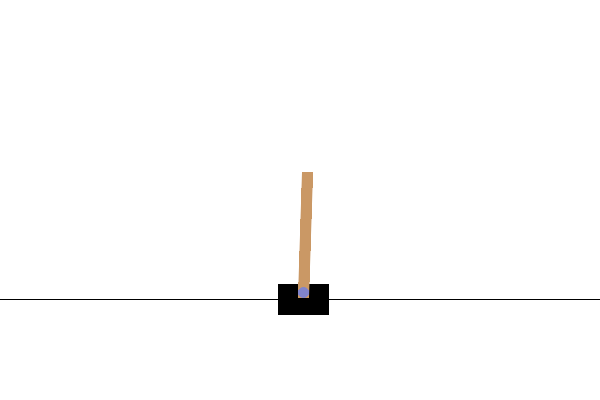

In [ ]:
image_array = env.render()
print(type(image_array))
print(f"(height, width, channels) = {image_array.shape}")
image_frame = PIL.Image.fromarray(image_array)

display(image_frame)

After making each action, the environment returns you the newly updated state, and if you didn't terminate the episode during the step, you also receive a **reward** of 1 point.

Then you continue the episode until it ends with the following conditions.  

1. Pole Angle is greater than ±12°
2. Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 500 (200 for the previous version)

In [ ]:
print(f"angle threshold = {(180/np.pi)*env.unwrapped.theta_threshold_radians}")
print(f"position threshold = {env.unwrapped.x_threshold}")
print(f"maximum steps for an episode = {env.spec.max_episode_steps}")

angle threshold = 12.0
position threshold = 2.4
maximum steps for an episode = 500


**This reward is the key idea of the reinforcement learning.** Your job now is to build a neural network model which:
- Takes in a vector of size 4 (`state`)
- Returns the integer of either 0 or 1 (`action`)
- Maximizes the amount of the rewards (`reward`) collected during an episode.

What you say to a neural network model is "umm.. can you keep moving the cart to prevent the pole from falling?", but it is not a very clear actionable direction. There is a big gap to be crossed from "preventing the pole from falling" to calculating the loss and updating the weights.

The **reward** is how we bridge the gap. The model's goal is to take the **state** as the input and return the best **action** as the output to maximize the **reward** for every step in the **episode**. For the first few episodes of the game, the model will not be very good at collecting the rewards, but with a carefully designed loss function, the model will continue to get better.

## Reinforcement Learning

### Action Reward Function

To play this game, you can think about the objective as being:

> "Given the current state of the game, learn the best way to steer the device to keep the pole upright."

Now, let's think about how we can build a neural network model that can play this game of Cart Pole.

If you're trying to predict the action to take, you can have the model return a probability value for a given state $p_t = p(s_t)$ between 0 and 1, and you can push the cart to the left if $p_t$ is closer to 0 or to the right if $p_t$ is closer to 1.

The nice thing about this $p_t$ is that it is **differentiable**, which is always useful for training neural network models! You can imagine having a function $Q(s_t, a_t)$ that estimates how much reward can be collected if you took an action of $a_t$ at the state of $s_t$. Then you can think of a loss function that looks kind of like this.

$$
\textrm{Loss} = -\sum_{t=1}^{T}
\big[ \log(1 - p_t)Q(s_t, \langle \textrm{push left} \rangle)
+ \log(p_t) Q(s_t, \langle \textrm{push right} \rangle) \big]
\text{ with $T=$ episode length.}$$

Take a moment to see what this loss function does:
- If there's more reward to be collected by pushing the cart to the left $Q(s_t, \langle \textrm{push left} \rangle)$, then it will try to make $p_t$ closer to 0.
- Conversely, if the reward is greater to the right $Q(s_t, \langle \textrm{push right} \rangle)$, the $p_t$ has to be closer to 1.

This magical function $Q(s_t, a_t)$ is called the **action reward function** in the literature, but the question is how do we find it?

### Discounted Reward Function

The answer is that we don't! We approximate it with something easier to find!

To help us find a suitable candidate, we can look into the reward function.
- $R(s_t)$ is the reward of a particular state.
- $\sum_{t=1}^{T} R(s_{t})$ is the total reward of an episode which ends on time step $T$.
- $\sum_{t=t_1}^{T} R(s_{t})$ is the total reward for the states from the step $t_1$ to the end of the episode.

Do you see how this is associated with $Q$ yet?

- $Q(s_t, a_t)$ is the *expected reward* of future states assuming $a_t$ was taken from state $s_t$.
- $\sum_{t=t_1}^{T} R(s_{t})$ is the *realized reward* of that for a specific episode.

Therefore, we can simply take $\sum_{t=t_1}^{T} R(s_{t})$ and assert that this will average out to $Q(s_t, a_t)$ as more episodes are tested.

<!-- We can do this by tracking the sum of the all rewards collected from state $s_t$ until the end of the episode, which we call the **discounted reward function** $D(s_t, a_t)$. When we sum the rewards, we discount the rewards further back in the future, because the future too far away from the present is not very relevant to the present.

Notice that $D(s_t, a_t)$ is not exactly the same as $Q(s_t, a_t)$.
- $Q(s_t, a_t)$ is the *expected amount* of the reward that can further be collected from that episode if you find yourself at the state $s_t$ and take the action $a_t$.
- $D(s_t, a_t)$ is what happened in that particular single episode. During that episode, you might have done something different at the next step, which could have changed the value of $D(s_t, a_t)$.

So, $D(s_t, a_t)$ is really a random draw from all the possibilities of rewards that can be collected after performing $a_t$ from $s_t$. However, $D(s_t, a_t)$ is still similar enough to $Q(s_t, a_t)$, because you can play the game as many times as you want. The value of $D(s_t, a_t)$ can change from one episode to another, but the average of enough many values of $D(s_t, a_t)$ is the same as $Q(s_t, a_t)$. **This is not an easy concept to understand, so it is fine to take some time to think about it or to talk about it with other students or the TAs.** -->

In practice, we will actually use the ***discounter reward function*** discounted by some factor $\gamma < 1$:
$$D_\gamma(s_t, a_t) = R(s_{t+1}) + \gamma R(s_{t+2}) + \gamma^2 R(s_{t+3}) + \cdots + \gamma^{T-t} R(s_{T})$$
where $s_{t+1}$ is the state where $a_t$ is applied to $s_t$.

Assuming that the reward is sparse such that only the terminal-state reward $R(s_T)$ is non-zero:
- Positive $R(s_T)$ implies that $D_{\gamma}(s_t, a_t) = \gamma^{T-t}R(s_T)$ ***decreases* to 0** as $T-t$ increases.
    - So then $D$ encourages states that are close to ending the game and result in high reward.
- Negative $R(s_T)$ implies that $D_{\gamma}(s_t, a_t) = \gamma^{T-t}R(s_T)$ ***increases* to 0** as $T-t$ increases.
    - So then $D$ encourages lower-penalty states that are far from ending the game, favoring slow finishes/continued play.
- Combined positive and negative rewards (and also when extended into non-sparse reward formulations) maintain this effect; **finish the game quickly with high reward, stay close to positive reward states, and distance away from negative reward states.**

### **[Check-Off 1]** Implement the discount function

It takes in a NumPy array `rewards`, which is the collection of the rewards for each timestep in an episode. Then, this function returns a NumPy array of the discounted rewards for each timestep, which are calculated by summing the rewards for each future timestep, discounted by how far in the future it is.

For example, in the simple case where the episode rewards are `[1, 3, 5]` and `discount_factor = .99`, we would calculate:
```
    dr_1 = 1 + 0.99 * 3 + 0.99^2 * 5 = 8.8705
    dr_2 = 3 + 0.99 * 5 = 7.95
    dr_3 = 5
```
and thus return `[8.8705, 7.95 , 5]`.

In [ ]:
def discount(rewards, discount_factor=.99):
    """
    :param rewards: array of rewards from an episode [r_{t1},r_{t2},...]
    :param discount_factor: Gamma discounting factor to use, defaults to .99
    :returns: discounted_rewards: array containing the discounted rewards
              for each timestep in the original rewards array
    """

    episode_length = len(rewards)
    discount_matrix = np.ones((episode_length, episode_length))

    # TODO:
    discount_matrix = np.triu(discount_matrix, k=1)
    discount_matrix = discount_matrix.cumsum(axis=1)
    # Output should be of the form:
    # discount_matrix = array([
    #    [0., 1., 2., 3., 4.],
    #    [0., 0., 1., 2., 3.],
    #    [0., 0., 0., 1., 2.],
    #    [0., 0., 0., 0., 1.],
    #    [0., 0., 0., 0., 0.]])

    # TODO: Calculate the coefficients for discounted rewards
    discount_matrix = np.triu(discount_factor ** discount_matrix)
    # discount_matrix = do something with np.triu
    # Output should be of the form:
    # discount_matrix = array([
    #    [1.    , f     , f**2  , f**3  , f**4  ],
    #    [0.    , 1.    , f     , f**2  , f**3  ],
    #    [0.    , 0.    , 1.    , f     , f**2  ],
    #    [0.    , 0.    , 0.    , 1.    , f     ],
    #    [0.    , 0.    , 0.    , 0.    , 1.    ]])

    rewards_vector = rewards.reshape(-1, 1)
    discounted_rewards = np.matmul(discount_matrix, rewards_vector).reshape(-1)

    return discounted_rewards

When done, you can now double-check your discounted rewards function below.

In [ ]:
rewards = np.array([1, 3, 5])
discounted_rewards = discount(rewards)
print("Expected result")
print(np.array([8.8705, 7.95 , 5]))
print("Your result")
print(discounted_rewards)

Expected result
[8.8705 7.95   5.    ]
Your result
[8.8705 7.95   5.    ]


### Reinforcement Learning

If you are okay with using $D(s_t, a_t)$, then we can have the following loss function and go ahead with building the model.

$$
\textrm{Loss} = - \sum_{t=1}^{T}  \log \big(p(a_t|s_t)\big) D(s_t, a_t)
$$

Here, $p(a_t|s_t)$ is a more general expression for the model's predicted probability that an action $a_t$ is the best action for the state $s_t$. In our case, it is $1 - p_t$ for the left push and $p_t$ for the right push. One sad thing here is that we can only observe $D(s_t, a_t)$ for the action that the model has taken. For example, if the action was "push left", we only know $D(s_t, \langle \textrm{push left} \rangle)$, but we do not know $D(s_t, \langle \textrm{push right} \rangle)$. In contrast, we can always have both $Q(s_t, \langle \textrm{push left} \rangle)$ and $Q(s_t, \langle \textrm{push right} \rangle)$ for any state $s_t$. However, that's okay. As the model learns, $p(a_t|s_t)$ quickly gets close to 1 for the optimal action.

This approach of "reinforcing" the model behavior to collect as much rewards as possible is called the **reinforcement learning**.

## Reinforcement Learning with Baseline

### Baseline

The vanila reinforcement learning method is good, but we can do something better. One problem is that the observation of $D(s_t, a_t)$ can be highly variable. A lot of different things can happen in the episode of the game after making that action $a_t$. So the gradient from the loss function will also be of high variance, which means that the weights will be pushed to a lot of random directions before they finally converge. This can make the training process unstable and inefficient. We need to add something to the loss function to make the training a bit more stable and efficient, and that something is called the **baseline**.

**Value Function:** Imagine that there is another function $V(s_t)$ that returns the best amount of rewards if you take the best set of actions afterwards. In other words, $V(s_t)$ is the same as $Q(s_t, a_t)$ with the best set of $a_t$ (i.e. optimal subsequent play). This function is called the **value function**, and except for very simple games, it is practically not possible to brute-force the game to obtain the exact form of this function. However, let's just pretend for now as if we had this function $V(s_t)$. Then, we can use it as our **baseline**. Look at this new function, called the advantage function:

$$
A(s_t, a_t) = D(s_t, a_t) - V(s_t)
$$

If you think hard enough, you will soon realize that we can use this $A(s_t, a_t)$ in our loss function.
- This function will output a large value when $a_t$ resulted in a good reward to make $D(s_t, a_t)$ as close to $V(s_t)$.
- On the other hand, $A(s_t, a_t)$ output a small value when the action $a_t$ was bad, so $D(s_t, a_t)$ is far away from $V(s_t)$.

The nice thing here is that the scale of $A(s_t, a_t)$ is so much less variable than $D(s_t, a_t)$ itself is, which means we can replace $D(s_t, a_t)$ with $A(s_t, a_t)$ in our loss function, and the training process will be more stable and efficient.

$$
\textrm{Loss} = - \sum_{t=1}^{T} \log \big( p(a_t|s_t) \big) \big( D(s_t, a_t) - V(s_t) \big)
$$

Then the question is where do we find the value function $V(s_t)$ in the first place? The answer is the **actor-critic model**.

### Actor-Critic Model

The main idea is to have the model predict not only $p(a_t|s_t)$ but also $V(s_t)$. We don't know what $V(s_t)$ is going to be exactly, but if the model is good enough $D(s_t, a_t)$ is going to be a random observation of $V(s_t)$ anyway. Remember that $V(s_t)$ is the same as $Q(s_t, a_t)$ with the best set of $a_t$ and that $D(s_t, a_t)$ is a random observation of $Q(s_t, a_t)$. If the model can figure out the best set of $a_t$, then we can use $D(s_t, a_t)$ to train the model's prediction of $V(s_t)$.

This means that the model will have to separate parts: the "actor" and the "critic".
- The "actor" part predicts $p(a_t|s_t)$ to determine the best ways to act.
- The "critic" part predicts $V(s_t)$ to determine the goodness of the resulting states.

As the model learns, the "critic" will get better at approximating the actual value of $V(s_t)$ so the "actor" returns better predictions of $p(a_t|s_t)$.

We then need two separate loss functions, one to train the actor network and the other for the critic network.

\begin{align*}
\textrm{Actor Loss} &= - \sum_{t=1}^{T} \log \big( p(a_t|s_t) \big) \big( D(s_t, a_t) - V(s_t) \big) \\
\textrm{Critic Loss} &= \sum_{t=1}^{T}  \big( D(s_t, a_t) - V(s_t) \big)^2
\end{align*}

Here, we have to be careful that the critic's weights are not trained by the actor loss function. The purpose of the critic is not to mimic that actor's behavior, but to provide the best baseline value to stabilize $D(s_t, a_t)$. In TensorFlow, we can achieve that with the `tf.stop_gradients` function.

## Model Implementation

<!-- $\color{blue}{\large \textbf{Check-off 2}}$ -->
### **[Check-Off 2]** Implement the actor-critic model

1. Implement the actor network and the critic network.
   - You can follow the suggested architecture, but you don't have to.
   - The actor network returns the probabilities $p(a_t|s_t)$ for all possible actions. Do not just return the probability for the single best action. For example, if the probability that the "left" is the best action is 0.3 for a given situation, and it is 0.7 for "right", return [0.3, 0.7], and do not return 0.7. For a batch of states, the output shape needs to be (batch_size, 2).
   - The critic network returns $V(s_t)$, a single scalar for a given state. For a batch of states, the output shape needs to be (batch_size, 1).
2. Implement the loss function.
   - It should return the total loss, which is the sum of the actor loss and the critic loss.
   - The variable `probabilities_taken_actions` is your collection of $p(a_t|s_t)$ for all time steps in this episode. It had to be recalculated here in the loss function, because the helper functions, which you will implement later, use NumPy arrays, which does not connect TensorFlow gradients.
   - The variable `values` is your collection of $V(s_t)$ for all time steps in this episode.
   - You should use the helper function `discount` to calculate $D(s_t, a_t)$, which you have already implemented above.
   - Note that when we calculate the advantage $A(s_t, a_t) = D(s_t, a_t) - V(s_t)$ to construct the actor loss, we use the `tf.stop_gradients` function to prevent training the critic network (which returns $V(s_t)$) with the actor loss.

In [ ]:
class ReinforceWithBaseline(tf.keras.Model):
    def __init__(self, state_size, num_actions):
        """
        :param state_size: number of parameters that define the state.
        :param num_actions: number of actions in an environment
        """
        super(ReinforceWithBaseline, self).__init__()
        self.num_actions = num_actions
        self.state_size = state_size

        learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 0.002,
            decay_steps = 150,
            decay_rate = 0.5,
            staircase = True,
            name = "half_rate_every_150_steps")

        self.optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_schedule)

        self.actor_size = 128
        self.actor = tf.keras.Sequential(
            layers = [
                # TODO:
                # 2 dense layers, leakyRELU as first activation function, and
                # final softmax activation
                # final output size = self.num_actions
                tf.keras.layers.Dense(self.actor_size, activation=tf.nn.leaky_relu),
                tf.keras.layers.Dense(self.num_actions, activation=tf.nn.softmax)
            ],
            name = "actor_network"
        )

        self.critic_size = 32
        self.critic = tf.keras.Sequential(
            layers = [
                # TODO:
                # 3 dense layers, leakyRELU as first and second activation
                # function, no activation on the final layer
                # final output size = 1
                tf.keras.layers.Dense(self.critic_size, activation=tf.nn.leaky_relu),
                tf.keras.layers.Dense(self.critic_size, activation=tf.nn.leaky_relu),
                tf.keras.layers.Dense(1, activation=None)
            ],
            name = "critic_network"
        )

    def call(self, states):
        probabilities = self.actor(states)
        return probabilities

    def value_function(self, states):
        values = self.critic(states)
        return values

    def loss(self, states, actions, discounted_rewards):
        """
        :param states: np.array (episode_length, state_size)
        :param actions: np.array (episode_length,)
        :param discounted_rewards: np.array (episode_length,)
        :return: loss, a TensorFlow scalar
        """

        probabilities_all_actions = self.call(states)
        values = self.value_function(states)

        actions = actions.reshape(-1, 1)
        # Hint: use tf.gather_nd (https://www.tensorflow.org/api_docs/python/tf/gather_nd)
        # to get the probabilities of the actions taken by the model
        # probabilities_taken_actions = tf.gather_nd(??,
        #                                            ??,
        #                                            batch_dims = 1)
        indices = tf.stack([tf.range(tf.shape(actions)[0]), actions[:, 0]], axis=-1)
        probabilities_taken_actions = tf.gather_nd(probabilities_all_actions, indices)

        # Here we stop gradient descent from training the critic
        # with the actor's loss

        advantages = tf.stop_gradient(discounted_rewards - values)

        actor_loss = (-1.0)*tf.reduce_sum(advantages*tf.math.log(
            probabilities_taken_actions))
        critic_loss = tf.reduce_sum((discounted_rewards - values)**2)

        total_loss = actor_loss + critic_loss

        return total_loss

Now the model should be capable of making predictions on $p(a_t|s_t)$ and $V(s_t)$, although they are going to be bad predictions because the model is not trained yet.

In [ ]:
state = env.reset()[0]
print(f"initial state = {state}")

model = ReinforceWithBaseline(state_size, num_actions)
prob = model(state[np.newaxis, :]).numpy().reshape(-1)
np.random.choice(num_actions, p = prob)  # non-deterministic action choice based on the calculated probabilities

print(f"probabilities for all possible actions = {prob}")
print(f"action taken = {action}")

value = model.critic(state[np.newaxis, :]).numpy().reshape(-1)
print(f"model's estimation of potential rewards = {value}")

initial state = [-0.04058227  0.04756223  0.02611397  0.02860643]
probabilities for all possible actions = [0.5008386  0.49916142]
action taken = 0
model's estimation of potential rewards = [0.00290453]


### Helper Functions

In [ ]:
def visualize_episode(env, model):
    """
    Generates arrays of states, actions, and rewards for one complete episode.

    :param env: The openai gym environment
    :param model: The model used to generate the actions
    :returns: List of image frames
    """

    state = env.reset()[0]
    state_size = env.observation_space.shape[0]
    num_actions = env.action_space.n

    image_frames = []

    max_steps_per_episode = env.spec.max_episode_steps

    for each_step in range(max_steps_per_episode):
        probability_all_actions = model(state.reshape(-1, state_size))\
                                      .numpy().reshape(-1)
        action = np.random.choice(num_actions, p = probability_all_actions)

        state, reward, is_done, _, _ = env.step(action)

        image_array = env.render()
        image_frame = PIL.Image.fromarray(image_array)
        image_frames.append(image_frame)

        if is_done:
            break

    return image_frames

<!-- $\color{blue}{\large \textbf{Check-off 3}}$ -->

### **[Check-off 3]** Implement the function `play_single_episode` below

In [ ]:
def play_single_episode(env, model):
    """
    Generates arrays of states, actions, and rewards for one complete episode.

    :param env: The openai gym environment
    :param model: The model used to generate the actions
    :returns: A tuple of arrays (states, actions, rewards),
              where each array has length equal to the number of timesteps in the episode
    """

    state = env.reset()[0]
    state_size = env.observation_space.shape[0]
    num_actions = env.action_space.n

    states, actions, rewards = [], [], []
    max_steps_per_episode = env.spec.max_episode_steps

    for each_step in range(max_steps_per_episode):
        # TODO:
        # 1. use model to generate probability distribution over next actions
        # 2. sample from this distribution to pick the next action
        # hint: take a look at the visualize_episode function above
        probability_all_actions = model(state.reshape(-1, state_size)).numpy().reshape(-1)
        action = np.random.choice(num_actions, p=probability_all_actions)

        # execute a step with the action...but remember to update the list
        # structures initialized above in the right order.

        next_state, reward, is_done, _, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

        if is_done:
            break

    states, actions, rewards = (
        np.array(states), np.array(actions), np.array(rewards)
    )

    return states, actions, rewards

Now, the model should be able to play the full episode. It's not going to be the best episode yet, because we haven't trained the model.

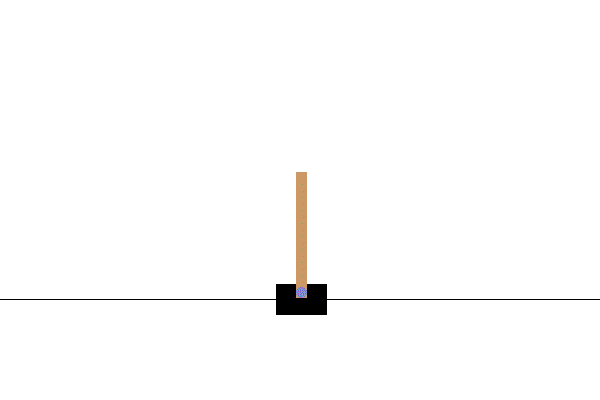

In [ ]:
state = env.reset()[0]

model = ReinforceWithBaseline(state_size, num_actions)

image_frames = visualize_episode(env, model)

image_frames[0].save("untrained_model.gif",
                     save_all = True,
                     duration = 20,
                     loop = 0,
                     append_images = image_frames[1:])

ip.display.Image(open(untrained_model_path ,"rb").read())

<!-- $\color{blue}{\large \textbf{Check-off 4}}$ -->

### **[Check-off 4]** Implement the train function below

This function should train your model for one episode. Each call to this function should generate a complete trajectory for one episode (arrays of states, action_probs, and rewards), and then train on that data to minimize your model loss. Also, return the total undiscounted sum of rewards for the episode. **Remember that one epoch is one episode**.

In [ ]:
def train(env, model):
    """
    :param env: The openai gym environment
    :param model: The model
    :returns: The total reward for the episode
    """

    with tf.GradientTape() as tape:
        # TODO:
        # 1. play a single episode of the game
        states, actions, rewards = play_single_episode(env, model)

        # 2. calculate the discounted rewards
        discounted_rewards = discount(rewards)

        # 3. calculate the loss
        loss = model.loss(states, actions, discounted_rewards)

    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # TODO:
    # 4. return the undiscounted sum of the rewards from the episode
    total_reward = np.sum(rewards)

    return total_reward

### Interacting with the model

If you have finished all to-do's above, the rest of the notebook should run without any trouble. For this model, 400 epochs (= 400 episodes) should be enough.

In [ ]:
model = ReinforceWithBaseline(state_size, num_actions)

n_epochs = 400
total_reward_list = []

print("training started")

for each_epoch in range(n_epochs):
    total_reward = train(env, model)
    total_reward_list.append(total_reward)

    if (each_epoch%20) == 0:
        print(f"epoch  = {each_epoch}, "
              f"total reward = {total_reward}")

print("training finished")

training started
epoch  = 0, total reward = 20.0
epoch  = 20, total reward = 16.0
epoch  = 40, total reward = 24.0
epoch  = 60, total reward = 31.0
epoch  = 80, total reward = 108.0
epoch  = 100, total reward = 40.0
epoch  = 120, total reward = 102.0
epoch  = 140, total reward = 282.0
epoch  = 160, total reward = 289.0
epoch  = 180, total reward = 500.0
epoch  = 200, total reward = 500.0
epoch  = 220, total reward = 500.0
epoch  = 240, total reward = 500.0
epoch  = 260, total reward = 500.0
epoch  = 280, total reward = 500.0
epoch  = 300, total reward = 500.0
epoch  = 320, total reward = 500.0
epoch  = 340, total reward = 500.0
epoch  = 360, total reward = 500.0
epoch  = 380, total reward = 500.0
training finished


In [ ]:
def visualize_training_process(total_rewards):
    fig, ax = plt.subplots()
    x_values = np.arange(0, len(total_rewards))
    y_values = total_rewards
    ax.plot(x_values, y_values)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Cumulative rewards')
    ax.set_title('Reward by Episode')
    ax.grid(True)

    return fig, ax

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Reward by Episode'}, xlabel='Episodes', ylabel='Cumulative rewards'>)

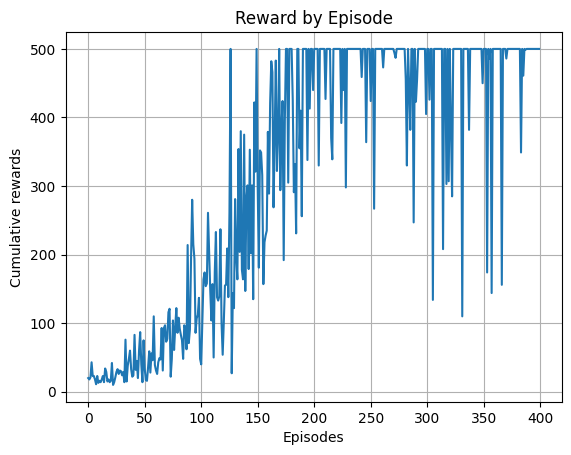

In [ ]:
visualize_training_process(total_reward_list)

You can re-run the following cell as many times you want to admire your model's performance.

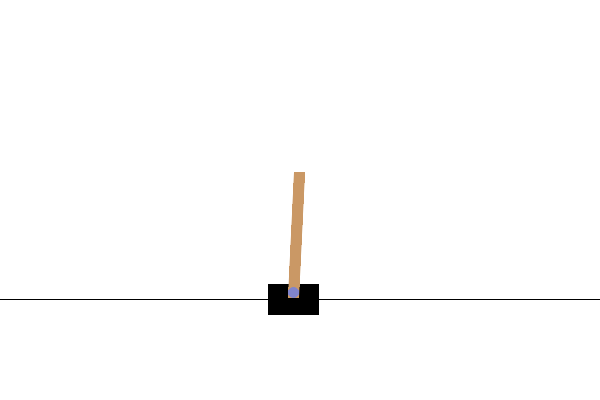

In [ ]:
image_frames = visualize_episode(env, model)

image_frames[0].save(trained_model_path,
                     save_all = True,
                     duration = 20,
                     loop = 0,
                     append_images = image_frames[1:])

ip.display.Image(open(trained_model_path, "rb").read())

## Acknowledgements & Sources

This lab is converted from a previous homework assignment by TA Yeunun Choo and edited by HTA Vadim Kudlay/Alex Guo